In [1]:
# Cell 1: imports and basic config
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from qulacs import QuantumState, QuantumCircuit
from qulacs.gate import X, Y, Z, RX, RY, RZ, CNOT

np.random.seed(42)


In [12]:
# Cell 2: download ATLAS Higgs data from CERN, scale 8 features, make train/val/test splits
import os, requests
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

DATA_URL = "http://opendata.cern.ch/record/328/files/atlas-higgs-challenge-2014-v2.csv.gz"
DATA_GZ = "atlas-higgs-challenge-2014-v2.csv.gz"

def download_higgs(url=DATA_URL, filename=DATA_GZ):
    if os.path.exists(filename):
        return
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        total = int(r.headers.get("Content-Length", 0) or 0)
        pbar = tqdm(total=total, unit="B", unit_scale=True, desc="Downloading Higgs CSV")
        with open(filename, "wb") as f:
            for chunk in r.iter_content(chunk_size=1024 * 1024):
                if chunk:
                    f.write(chunk)
                    pbar.update(len(chunk))
        pbar.close()

download_higgs()

df = pd.read_csv(DATA_GZ, compression="gzip")

# convert labels: signal 's' -> 1, background 'b' -> 0
df["Label"] = (df["Label"] == "s").astype(int)

non_feature_cols = ["EventId", "Weight", "KaggleSet", "KaggleWeight", "Label"]
feature_cols = [c for c in df.columns if c not in non_feature_cols]

X_full = df[feature_cols].to_numpy()
y_full = df["Label"].to_numpy()

# keep first 8 physics features for our 8-qubit QNN
X_8 = X_full[:, :8]

scaler = StandardScaler()
X_8 = scaler.fit_transform(X_8)

# sample 100k events for lighter quantum training, preserving class balance
X_sample, y_sample = resample(
    X_8, y_full, n_samples=100_000, stratify=y_full, random_state=42
)

# 80/10/10 split with stratification
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_sample, y_sample, test_size=0.1, stratify=y_sample, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1111, stratify=y_train_val, random_state=42
)


In [13]:
# Cell 3: sanity-check shapes and Higgs vs background balance in each split
for name, Xs, ys in [
    ("train", X_train, y_train),
    ("val",   X_val,   y_val),
    ("test",  X_test,  y_test),
]:
    unique, counts = np.unique(ys, return_counts=True)
    print(f"{name:5s}: X shape = {Xs.shape} | class counts = {dict(zip(unique, counts))}")


train: X shape = (80001, 8) | class counts = {np.int64(0): np.int64(52668), np.int64(1): np.int64(27333)}
val  : X shape = (9999, 8) | class counts = {np.int64(0): np.int64(6583), np.int64(1): np.int64(3416)}
test : X shape = (10000, 8) | class counts = {np.int64(0): np.int64(6583), np.int64(1): np.int64(3417)}


In [31]:
# Cell 3.5: preview a few rows of the raw Higgs dataset before preprocessing
df_preview = df.sample(5, random_state=42)
display(df_preview.head())

print("\nData columns:\n")
print(df.columns)

print("\nUnique labels:", df['Label'].unique())
print("Signal count:", (df['Label'] == 1).sum())
print("Background count:", (df['Label'] == 0).sum())


,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,KaggleSet,KaggleWeight
314903,414903,120.446,33.424,94.330,4.634,-999.000,-999.000,-999.000,2.872,4.634,...,-999.000,-999.000,-999.000,-999.000,-999.000,-0.000,0.000461,1,v,0.000839
638193,738193,82.420,62.550,50.525,30.852,2.575,205.076,1.413,2.474,30.739,...,3.040,0.796,41.509,0.465,-2.238,136.635,0.631642,0,v,1.148469
224007,324007,-999.000,83.006,44.854,2.950,-999.000,-999.000,-999.000,1.566,2.950,...,-999.000,-999.000,-999.000,-999.000,-999.000,0.000,1.391596,0,t,4.563959
35725,135725,132.118,20.056,102.543,84.839,-999.000,-999.000,-999.000,2.676,2.413,...,-0.325,-1.105,-999.000,-999.000,-999.000,82.433,0.702548,0,t,2.304116
163714,263714,76.616,4.876,46.783,47.051,-999.000,-999.000,-999.000,2.208,26.913,...,-1.645,-1.507,-999.000,-999.000,-999.000,40.670,0.022533,0,t,0.073899



Data columns:

Index(['EventId', 'DER_mass_MMC', 'DER_mass_transverse_met_lep',
       'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet',
       'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt',
       'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality',
       'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi',
       'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi',
       'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt',
       'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt',
       'Weight', 'Label', 'KaggleSet', 'KaggleWeight'],
      dtype='object')

Unique labels: [1 0]
Signal count: 279560
Background count: 538678


In [14]:
# Cell 4: amplitude encoding helper for 8-feature Higgs events into 3-qubit states
n_features = 8
n_qubits = int(np.ceil(np.log2(n_features)))  # 3 qubits → 2^3 = 8 amplitudes

def make_amplitude_state(x: np.ndarray) -> QuantumState:
    """Return a Qulacs QuantumState with amplitudes proportional to x (ℓ2-normalized)."""
    x = x.astype(np.float64)
    amp = np.zeros(2**n_qubits, dtype=np.complex128)
    amp[:n_features] = x
    norm = np.linalg.norm(amp)
    if norm == 0:
        amp[0] = 1.0
    else:
        amp /= norm
    state = QuantumState(n_qubits)
    state.load(amp)
    return state


In [22]:
# Cell 5 VQC ansatz, observable on Z₀, and forward pass
from qulacs import Observable

obs_z0 = Observable(n_qubits)
obs_z0.add_operator(1.0, "Z 0")

def build_vqc_circuit(params: np.ndarray, n_qubits: int, n_layers: int) -> QuantumCircuit:
    assert params.size == 2 * n_qubits * n_layers
    circuit = QuantumCircuit(n_qubits)
    idx = 0
    for _ in range(n_layers):
        for q in range(n_qubits):
            circuit.add_gate(RY(q, params[idx])); idx += 1
            circuit.add_gate(RZ(q, params[idx])); idx += 1
        for q in range(n_qubits):
            circuit.add_gate(CNOT(q, (q + 1) % n_qubits))
    return circuit

def vqc_expectation(x: np.ndarray, params: np.ndarray, n_layers: int = 2) -> float:
    state = make_amplitude_state(x)
    circuit = build_vqc_circuit(params, n_qubits=n_qubits, n_layers=n_layers)
    circuit.update_quantum_state(state)
    return obs_z0.get_expectation_value(state)


In [23]:
# Cell 6 : loss, numerical gradient, and Adam helper (no parameter-shift)
from tqdm.auto import tqdm

def logit_from_expectation(exp_z):
    return 0.5 * (exp_z + 1.0)  # ⟨Z⟩ ∈ [-1,1] → p ∈ [0,1]

def bce_loss(y_true, y_prob, eps=1e-9):
    y_prob = np.clip(y_prob, eps, 1.0 - eps)
    return -np.mean(y_true * np.log(y_prob) + (1 - y_true) * np.log(1 - y_prob))

def batch_expectations(X_batch, params, n_layers=2):
    return np.array([vqc_expectation(x, params, n_layers=n_layers) for x in X_batch])

def loss_on_batch(X_batch, y_batch, params, n_layers=2):
    exp = batch_expectations(X_batch, params, n_layers=n_layers)
    p = logit_from_expectation(exp)
    return bce_loss(y_batch, p)

def numerical_gradient(X_batch, y_batch, params, n_layers=2, eps=0.1):
    grad = np.zeros_like(params)
    for k in range(len(params)):
        params_plus = params.copy();  params_plus[k] += eps
        params_minus = params.copy(); params_minus[k] -= eps
        L_plus = loss_on_batch(X_batch, y_batch, params_plus, n_layers=n_layers)
        L_minus = loss_on_batch(X_batch, y_batch, params_minus, n_layers=n_layers)
        grad[k] = (L_plus - L_minus) / (2.0 * eps)
    return grad

# Adam state
class AdamState:
    def __init__(self, n_params, lr=0.05, beta1=0.9, beta2=0.999, eps=1e-8):
        self.m = np.zeros(n_params)
        self.v = np.zeros(n_params)
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.t = 0

    def step(self, params, grad):
        self.t += 1
        self.m = self.beta1 * self.m + (1 - self.beta1) * grad
        self.v = self.beta2 * self.v + (1 - self.beta2) * (grad ** 2)
        m_hat = self.m / (1 - self.beta1 ** self.t)
        v_hat = self.v / (1 - self.beta2 ** self.t)
        return params - self.lr * m_hat / (np.sqrt(v_hat) + self.eps)


In [25]:
# Cell 7: training function using Adam + progress bar
def train_vqc(X_train_sub, y_train_sub, X_val_sub, y_val_sub,
              params, n_layers=2, n_epochs=20, eps=0.1):
    
    adam = AdamState(n_params=len(params), lr=0.05)
    history = {"train_loss": [], "val_loss": []}
    
    pbar = tqdm(range(1, n_epochs+1), desc="Training VQC (Adam)")
    
    for epoch in pbar:
        grad = numerical_gradient(X_train_sub, y_train_sub,
                                  params, n_layers=n_layers, eps=eps)
        params = adam.step(params, grad)
        
        train_loss = loss_on_batch(X_train_sub, y_train_sub,
                                   params, n_layers=n_layers)
        val_loss   = loss_on_batch(X_val_sub,   y_val_sub,
                                   params, n_layers=n_layers)
        
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        pbar.set_postfix({"train": f"{train_loss:.4f}",
                          "val":   f"{val_loss:.4f}"})
    
    return params, history


In [27]:
# Cell 8: run training on small subset (visual-friendly)
np.random.seed(42)
train_idx = np.random.choice(len(X_train), size=256, replace=False)
val_idx   = np.random.choice(len(X_val), size=256, replace=False)

X_train_sub, y_train_sub = X_train[train_idx], y_train[train_idx]
X_val_sub,   y_val_sub   = X_val[val_idx],   y_val[val_idx]

params = 0.01 * np.random.randn(2 * n_qubits * n_layers)

params_trained, history = train_vqc(
    X_train_sub, y_train_sub, X_val_sub, y_val_sub,
    params, n_layers=n_layers, n_epochs=100
)


Training VQC (Adam):   0%|          | 0/100 [00:00<?, ?it/s]

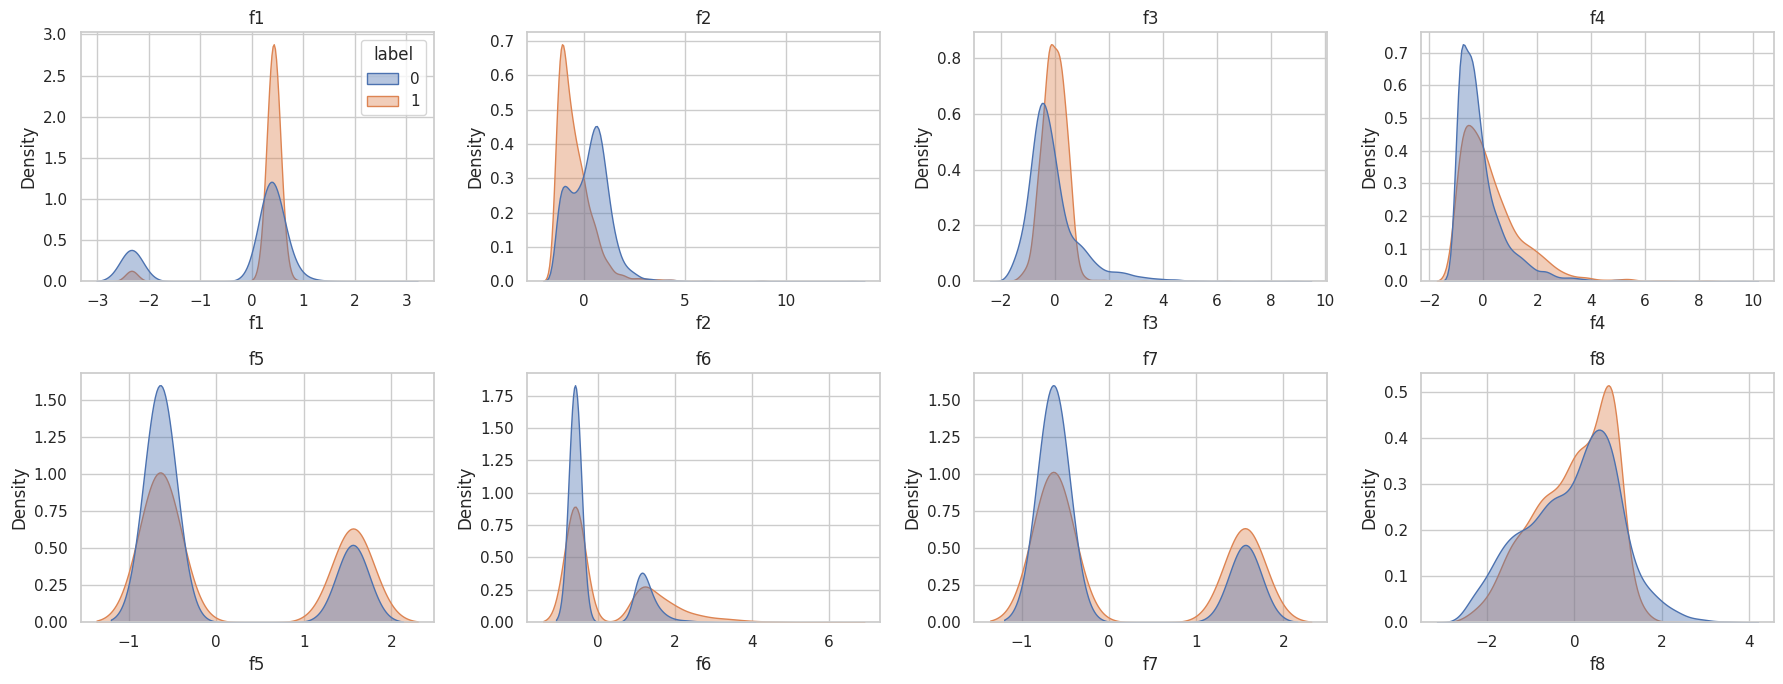

In [29]:
# Cell 9: feature-wise histograms for Higgs signal vs background (train subset)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# small subset for plotting
plot_idx = np.random.choice(len(X_train), size=5000, replace=False)
X_plot = X_train[plot_idx]
y_plot = y_train[plot_idx]

df_plot = pd.DataFrame(X_plot, columns=[f"f{i+1}" for i in range(X_plot.shape[1])])
df_plot["label"] = y_plot  # 1 = Higgs signal, 0 = background

sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 4, figsize=(18, 7))
axes = axes.ravel()
for i, col in enumerate([f"f{i+1}" for i in range(8)]):
    sns.kdeplot(
        data=df_plot, x=col, hue="label",
        common_norm=False, fill=True, alpha=0.4, ax=axes[i],
        legend=(i == 0)
    )
    axes[i].set_title(col)
plt.tight_layout()
plt.show()


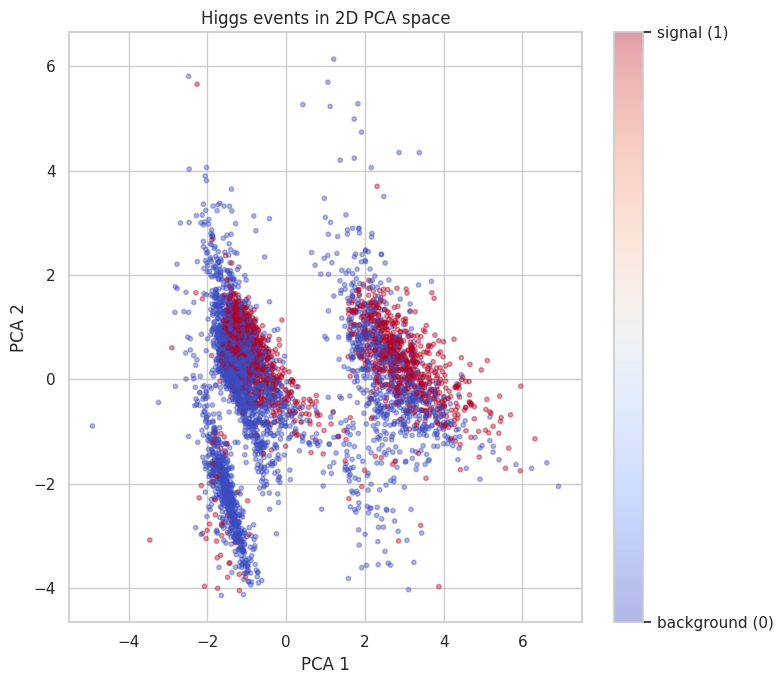

In [30]:
# Cell 10: 2D PCA projection of events colored by Higgs signal/background
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_plot)

plt.figure(figsize=(8, 7))
scatter = plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=y_plot, cmap="coolwarm", alpha=0.4, s=10
)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Higgs events in 2D PCA space")
cbar = plt.colorbar(scatter, ticks=[0, 1])
cbar.ax.set_yticklabels(["background (0)", "signal (1)"])
plt.tight_layout()
plt.show()


In [32]:
# Cell 11: generic amplitude VQC for variable #qubits and layers (4, 8, 12...)
def make_amplitude_state_n(x: np.ndarray, n_qubits: int) -> QuantumState:
    """Amplitude-encode x into an n-qubit state (padding with zeros if needed)."""
    x = x.astype(np.float64)
    dim = 2 ** n_qubits
    amp = np.zeros(dim, dtype=np.complex128)
    d = min(len(x), dim)
    amp[:d] = x[:d]
    norm = np.linalg.norm(amp)
    if norm == 0:
        amp[0] = 1.0
    else:
        amp /= norm
    state = QuantumState(n_qubits)
    state.load(amp)
    return state

def build_vqc_circuit_n(params: np.ndarray, n_qubits: int, n_layers: int) -> QuantumCircuit:
    """Hardware-efficient ansatz on n qubits (Ry/Rz + CNOT ring per layer)."""
    assert params.size == 2 * n_qubits * n_layers
    circuit = QuantumCircuit(n_qubits)
    idx = 0
    for _ in range(n_layers):
        for q in range(n_qubits):
            circuit.add_gate(RY(q, params[idx])); idx += 1
            circuit.add_gate(RZ(q, params[idx])); idx += 1
        for q in range(n_qubits):
            circuit.add_gate(CNOT(q, (q + 1) % n_qubits))
    return circuit

def vqc_expectation_n(x: np.ndarray, params: np.ndarray, n_qubits: int, n_layers: int) -> float:
    """Run n-qubit VQC on amplitude-encoded x and return ⟨Z₀⟩."""
    from qulacs import Observable
    state = make_amplitude_state_n(x, n_qubits)
    circuit = build_vqc_circuit_n(params, n_qubits, n_layers)
    circuit.update_quantum_state(state)
    obs = Observable(n_qubits); obs.add_operator(1.0, "Z 0")
    return obs.get_expectation_value(state)


In [33]:
# Cell 12: helpers for benchmarking configs (loss, gradient, accuracy) with variable qubits
def batch_expectations_n(X_batch, params, n_qubits, n_layers):
    return np.array([vqc_expectation_n(x, params, n_qubits, n_layers) for x in X_batch])

def loss_on_batch_n(X_batch, y_batch, params, n_qubits, n_layers):
    exp = batch_expectations_n(X_batch, params, n_qubits, n_layers)
    p = logit_from_expectation(exp)
    return bce_loss(y_batch, p)

def numerical_gradient_n(X_batch, y_batch, params, n_qubits, n_layers, eps=0.1):
    grad = np.zeros_like(params)
    for k in range(len(params)):
        params_plus = params.copy();  params_plus[k] += eps
        params_minus = params.copy(); params_minus[k] -= eps
        L_plus = loss_on_batch_n(X_batch, y_batch, params_plus, n_qubits, n_layers)
        L_minus = loss_on_batch_n(X_batch, y_batch, params_minus, n_qubits, n_layers)
        grad[k] = (L_plus - L_minus) / (2.0 * eps)
    return grad

def accuracy_on_batch(X_batch, y_batch, params, n_qubits, n_layers):
    exp = batch_expectations_n(X_batch, params, n_qubits, n_layers)
    p = logit_from_expectation(exp)
    y_hat = (p >= 0.5).astype(int)
    return (y_hat == y_batch).mean()


In [34]:
# Cell 13: training + evaluation helper for one (n_qubits, n_layers) amplitude-encoded VQC
def train_and_eval_amp_config(n_qubits, n_layers,
                              X_train, y_train, X_val, y_val, X_test, y_test,
                              train_size=128, val_size=256, test_size=512,
                              n_epochs=3, eps=0.1, lr=0.05, seed=0):
    np.random.seed(seed)
    tr_idx = np.random.choice(len(X_train), size=train_size, replace=False)
    va_idx = np.random.choice(len(X_val),   size=val_size,   replace=False)
    te_idx = np.random.choice(len(X_test),  size=test_size,  replace=False)

    X_tr, y_tr = X_train[tr_idx], y_train[tr_idx]
    X_va, y_va = X_val[va_idx],   y_val[va_idx]
    X_te, y_te = X_test[te_idx],  y_test[te_idx]

    n_params = 2 * n_qubits * n_layers
    params = 0.01 * np.random.randn(n_params)
    adam = AdamState(n_params=n_params, lr=lr)

    for epoch in tqdm(range(1, n_epochs + 1),
                      desc=f"{n_qubits}q L{n_layers} (amp)", leave=False):
        grad = numerical_gradient_n(X_tr, y_tr, params, n_qubits, n_layers, eps=eps)
        params = adam.step(params, grad)

    metrics = {
        "n_qubits": n_qubits,
        "n_layers": n_layers,
        "train_loss": loss_on_batch_n(X_tr, y_tr, params, n_qubits, n_layers),
        "val_loss":   loss_on_batch_n(X_va, y_va, params, n_qubits, n_layers),
        "test_loss":  loss_on_batch_n(X_te, y_te, params, n_qubits, n_layers),
        "train_acc":  accuracy_on_batch(X_tr, y_tr, params, n_qubits, n_layers),
        "val_acc":    accuracy_on_batch(X_va, y_va, params, n_qubits, n_layers),
        "test_acc":   accuracy_on_batch(X_te, y_te, params, n_qubits, n_layers),
    }
    return params, metrics


4q L1 (amp):   0%|          | 0/3 [00:00<?, ?it/s]

4q L1 → test_acc = 0.473, val_acc = 0.453


4q L2 (amp):   0%|          | 0/3 [00:00<?, ?it/s]

4q L2 → test_acc = 0.486, val_acc = 0.465


8q L1 (amp):   0%|          | 0/3 [00:00<?, ?it/s]

8q L1 → test_acc = 0.473, val_acc = 0.453


8q L2 (amp):   0%|          | 0/3 [00:00<?, ?it/s]

8q L2 → test_acc = 0.484, val_acc = 0.445


12q L1 (amp):   0%|          | 0/3 [00:00<?, ?it/s]

12q L1 → test_acc = 0.473, val_acc = 0.453


12q L2 (amp):   0%|          | 0/3 [00:00<?, ?it/s]

12q L2 → test_acc = 0.490, val_acc = 0.453


,n_qubits,n_layers,train_loss,val_loss,test_loss,train_acc,val_acc,test_acc
0,4,1,0.900359,0.835415,0.828536,0.382812,0.453125,0.472656
1,4,2,0.728381,0.797075,0.753490,0.507812,0.464844,0.486328
2,8,1,0.884031,0.823591,0.816560,0.382812,0.453125,0.472656
3,8,2,0.723335,0.787117,0.748870,0.507812,0.445312,0.484375
4,12,1,0.869787,0.813319,0.806190,0.382812,0.453125,0.472656
5,12,2,0.716007,0.777194,0.741123,0.507812,0.453125,0.490234


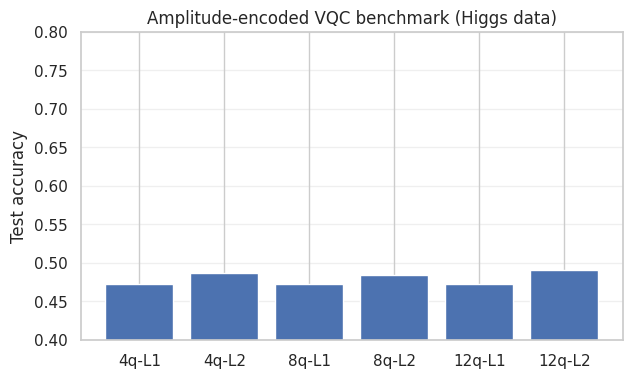

In [35]:
# Cell 14: benchmark amplitude configs (4, 8, 12 qubits × 1–2 layers) and visualize test accuracy
amp_configs = [(4, 1), (4, 2), (8, 1), (8, 2), (12, 1), (12, 2)]
results_amp = []

for nq, nl in amp_configs:
    _, metrics = train_and_eval_amp_config(
        nq, nl, X_train, y_train, X_val, y_val, X_test, y_test,
        train_size=128, val_size=256, test_size=512,
        n_epochs=3, eps=0.1, lr=0.05, seed=42
    )
    results_amp.append(metrics)
    print(f"{nq}q L{nl} → test_acc = {metrics['test_acc']:.3f}, val_acc = {metrics['val_acc']:.3f}")

results_amp_df = pd.DataFrame(results_amp)
display(results_amp_df)

plt.figure(figsize=(7, 4))
labels = [f"{m['n_qubits']}q-L{m['n_layers']}" for m in results_amp]
plt.bar(labels, [m["test_acc"] for m in results_amp])
plt.ylabel("Test accuracy")
plt.title("Amplitude-encoded VQC benchmark (Higgs data)")
plt.ylim(0.4, 0.8)
plt.grid(axis="y", alpha=0.3)
plt.show()


In [55]:
# Cell 15: amplitude training with mini-batches, Adam, early stopping, best val/loss in tqdm
import os

def minibatches(X, y, batch_size, rng):
    idx = rng.permutation(len(X))
    for start in range(0, len(X), batch_size):
        batch_idx = idx[start:start + batch_size]
        yield X[batch_idx], y[batch_idx]

def train_amp_config_serious(
    n_qubits, n_layers,
    X_train, y_train, X_val, y_val,
    n_epochs=80, train_size=4000, val_size=2000,
    batch_size=64, eps=0.05, lr=0.02, seed=0,
    model_dir="models_amp", patience=5,
):
    os.makedirs(model_dir, exist_ok=True)
    rng = np.random.default_rng(seed)

    tr_idx = rng.choice(len(X_train), size=train_size, replace=False)
    va_idx = rng.choice(len(X_val),   size=val_size,   replace=False)
    X_tr, y_tr = X_train[tr_idx], y_train[tr_idx]
    X_va, y_va = X_val[va_idx],   y_val[va_idx]

    n_params = 2 * n_qubits * n_layers
    params = 0.01 * rng.standard_normal(n_params)
    adam = AdamState(n_params=n_params, lr=lr)

    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    best_val_loss = float("inf")
    best_val_acc = 0.0
    best_params = params.copy()
    epochs_without_improve = 0
    model_path = os.path.join(model_dir, f"amp_{n_qubits}q_L{n_layers}_best.npy")

    pbar = tqdm(range(1, n_epochs + 1),
                desc=f"Training amp {n_qubits}q-L{n_layers}",
                leave=True)

    for epoch in pbar:
        for X_b, y_b in minibatches(X_tr, y_tr, batch_size, rng):
            grad = numerical_gradient_n(X_b, y_b, params, n_qubits, n_layers, eps=eps)
            params = adam.step(params, grad)

        train_loss = loss_on_batch_n(X_tr, y_tr, params, n_qubits, n_layers)
        val_loss   = loss_on_batch_n(X_va, y_va, params, n_qubits, n_layers)
        train_acc  = accuracy_on_batch(X_tr, y_tr, params, n_qubits, n_layers)
        val_acc    = accuracy_on_batch(X_va, y_va, params, n_qubits, n_layers)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        pbar.set_postfix({
            "train":    f"{train_loss:.3f}",
            "val":      f"{val_loss:.3f}",
            "best_val": f"{best_val_loss:.3f}" if best_val_loss < float("inf") else "inf",
            "best_acc": f"{best_val_acc:.3f}",
        })

        if val_loss < best_val_loss - 1e-4:
            best_val_loss = val_loss
            best_val_acc = val_acc
            best_params = params.copy()
            np.save(model_path, best_params)
            epochs_without_improve = 0
        else:
            epochs_without_improve += 1
            if epochs_without_improve >= patience:
                print(f"\nEarly stopping after {epoch} epochs (no val improvement for {patience}).")
                break

    return best_params, history, model_path


Training amp 8q-L2:   0%|          | 0/20 [00:00<?, ?it/s]


Early stopping after 10 epochs (no val improvement for 4).
Best 8q-L2 amplitude VQC → test accuracy = 0.655
Model saved at: models_amp/amp_8q_L2_best.npy


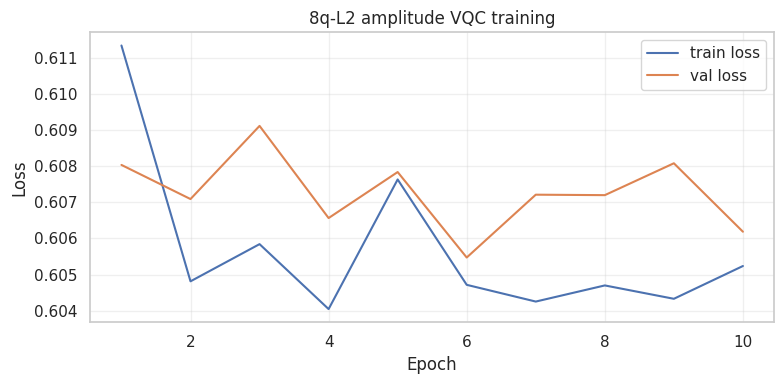

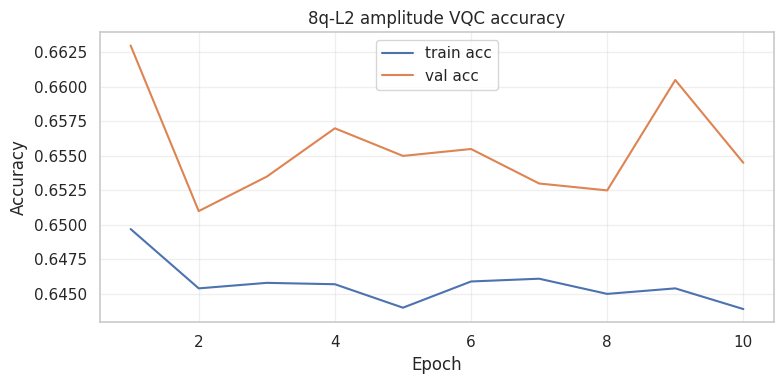

In [46]:
# Cell 16: run a serious training run for one config (e.g. 8 qubits, 2 layers) and evaluate + plot
n_qubits_amp = 8
n_layers_amp = 2

train_size = 10000   # 80001
val_size   = 2000     # 9999

best_params_8q2L, hist_8q2L, model_path_8q2L = train_amp_config_serious(
    n_qubits_amp, n_layers_amp,
    X_train, y_train, X_val, y_val,
    n_epochs=20,
    train_size=train_size,
    val_size=val_size,
    batch_size=64, eps=0.05, lr=0.02,
    seed=42, model_dir="models_amp", patience=4,
)
test_acc_8q2L = accuracy_on_batch(X_test, y_test, best_params_8q2L, n_qubits_amp, n_layers_amp)
print(f"Best 8q-L2 amplitude VQC → test accuracy = {test_acc_8q2L:.3f}")
print(f"Model saved at: {model_path_8q2L}")

# simple loss/accuracy curves
epochs = np.arange(1, len(hist_8q2L["train_loss"]) + 1)
plt.figure(figsize=(8, 4))
plt.plot(epochs, hist_8q2L["train_loss"], label="train loss")
plt.plot(epochs, hist_8q2L["val_loss"],   label="val loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("8q-L2 amplitude VQC training")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(epochs, hist_8q2L["train_acc"], label="train acc")
plt.plot(epochs, hist_8q2L["val_acc"],   label="val acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("8q-L2 amplitude VQC accuracy")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()
plt.show()


In [47]:
# Cell 17: quick check of effective split sizes (so you see what we’re using)
print("Train size used:", train_size)
print("Val size used  :", val_size)
print("Test size      :", len(X_test))
print("Approx ratios  : "
      f"{train_size/(train_size+val_size+len(X_test)):.2f} train, "
      f"{val_size/(train_size+val_size+len(X_test)):.2f} val, "
      f"{len(X_test)/(train_size+val_size+len(X_test)):.2f} test")


Train size used: 10000
Val size used  : 2000
Test size      : 10000
Approx ratios  : 0.45 train, 0.09 val, 0.45 test


In [56]:
# Cell 17: benchmark 4q/8q with more layers (L2 & L3), drop 12q
sub_rng = np.random.default_rng(123)

train_idx_sub = sub_rng.choice(len(X_train), size=8000, replace=False)
val_idx_sub   = sub_rng.choice(len(X_val),   size=1000, replace=False)
test_idx_sub  = sub_rng.choice(len(X_test),  size=1000, replace=False)

X_train_sub, y_train_sub = X_train[train_idx_sub], y_train[train_idx_sub]
X_val_sub,   y_val_sub   = X_val[val_idx_sub],   y_val[val_idx_sub]
X_test_sub,  y_test_sub  = X_test[test_idx_sub], y_test[test_idx_sub]

amp_configs_serious = [(4, 2), (4, 6), (8, 2), (8, 4)]
results_amp_serious = []
histories_amp = {}

for nq, nl in amp_configs_serious:
    print(f"\n=== Training {nq}q-L{nl} (amp) on 8k train / 1k val / 1k test ===")
    best_params, hist, model_path = train_amp_config_serious(
        nq, nl,
        X_train_sub, y_train_sub,
        X_val_sub,   y_val_sub,
        n_epochs=80,
        train_size=len(X_train_sub),
        val_size=len(X_val_sub),
        batch_size=64,
        eps=0.05, lr=0.02,
        seed=42,
        model_dir="models_amp",
        patience=4,
    )
    test_loss = loss_on_batch_n(X_test_sub, y_test_sub, best_params, nq, nl)
    test_acc  = accuracy_on_batch(X_test_sub, y_test_sub, best_params, nq, nl)
    results_amp_serious.append({
        "n_qubits": nq,
        "n_layers": nl,
        "train_size": len(X_train_sub),
        "val_size": len(X_val_sub),
        "test_size": len(X_test_sub),
        "test_loss": test_loss,
        "test_acc": test_acc,
        "best_model_path": model_path,
    })
    histories_amp[(nq, nl)] = hist
    print(f"{nq}q-L{nl} → test loss = {test_loss:.3f}, test accuracy = {test_acc:.3f} (model: {model_path})")

results_amp_serious_df = pd.DataFrame(results_amp_serious)
display(results_amp_serious_df)



=== Training 4q-L2 (amp) on 8k train / 1k val / 1k test ===


Training amp 4q-L2:   0%|          | 0/80 [00:00<?, ?it/s]


Early stopping after 14 epochs (no val improvement for 4).
4q-L2 → test loss = 0.607, test accuracy = 0.670 (model: models_amp/amp_4q_L2_best.npy)

=== Training 4q-L6 (amp) on 8k train / 1k val / 1k test ===


Training amp 4q-L6:   0%|          | 0/80 [00:00<?, ?it/s]


Early stopping after 14 epochs (no val improvement for 4).
4q-L6 → test loss = 0.543, test accuracy = 0.723 (model: models_amp/amp_4q_L6_best.npy)

=== Training 8q-L2 (amp) on 8k train / 1k val / 1k test ===


Training amp 8q-L2:   0%|          | 0/80 [00:00<?, ?it/s]


Early stopping after 10 epochs (no val improvement for 4).
8q-L2 → test loss = 0.608, test accuracy = 0.638 (model: models_amp/amp_8q_L2_best.npy)

=== Training 8q-L4 (amp) on 8k train / 1k val / 1k test ===


Training amp 8q-L4:   0%|          | 0/80 [00:00<?, ?it/s]


Early stopping after 14 epochs (no val improvement for 4).
8q-L4 → test loss = 0.554, test accuracy = 0.712 (model: models_amp/amp_8q_L4_best.npy)


,n_qubits,n_layers,train_size,val_size,test_size,test_loss,test_acc,best_model_path
0,4,2,8000,1000,1000,0.606660,0.670,models_amp/amp_4q_L2_best.npy
1,4,6,8000,1000,1000,0.543373,0.723,models_amp/amp_4q_L6_best.npy
2,8,2,8000,1000,1000,0.607746,0.638,models_amp/amp_8q_L2_best.npy
3,8,4,8000,1000,1000,0.553860,0.712,models_amp/amp_8q_L4_best.npy


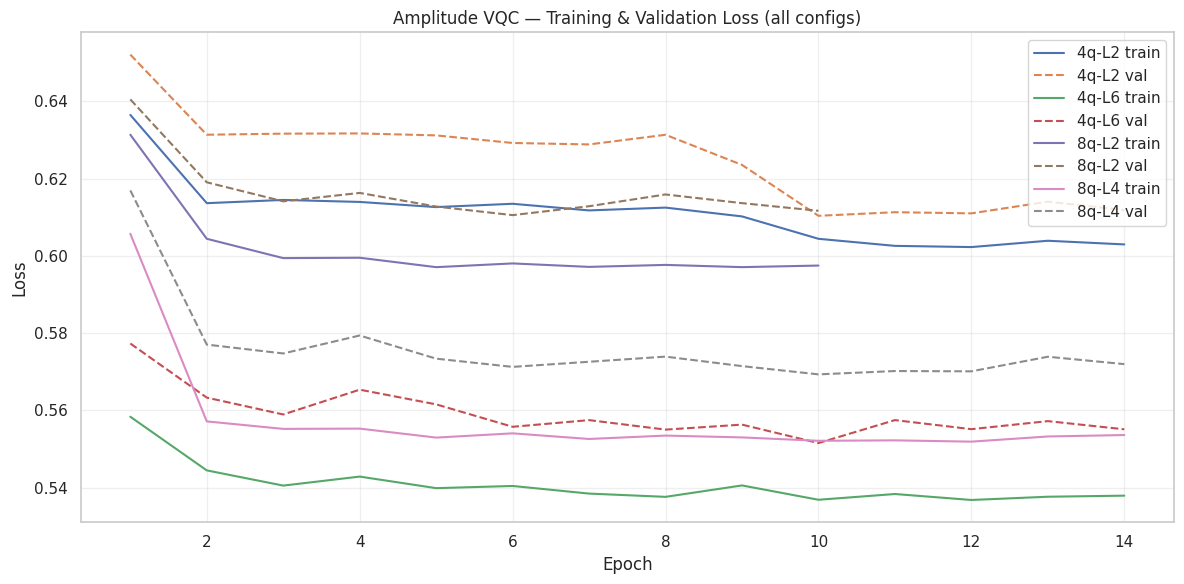

In [57]:
# Cell 18: plot loss curves for all configs from histories_amp
plt.figure(figsize=(12, 6))

for (nq, nl), hist in histories_amp.items():
    epochs = np.arange(1, len(hist["train_loss"]) + 1)
    label_train = f"{nq}q-L{nl} train"
    label_val   = f"{nq}q-L{nl} val"

    plt.plot(epochs, hist["train_loss"], label=label_train)
    plt.plot(epochs, hist["val_loss"],   linestyle="--", label=label_val)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Amplitude VQC — Training & Validation Loss (all configs)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [58]:
# Cell 19: angle-encoding VQC forward pass (RX/RZ data layer + Ry/Rz trainable + CNOT ring)
n_features = 8  # we use the same 8 Higgs features

def apply_angle_encoding(circuit: QuantumCircuit, x: np.ndarray, n_qubits: int, data_scale=np.pi/2):
    x = x[:n_features].astype(float)
    if n_qubits == 4 and len(x) >= 8:  # 2 features per qubit
        for q in range(4):
            circuit.add_gate(RX(q, data_scale * x[2*q]))
            circuit.add_gate(RZ(q, data_scale * x[2*q + 1]))
    elif n_qubits == 8 and len(x) >= 8:  # 1 feature per qubit, reused
        for q in range(8):
            circuit.add_gate(RX(q, data_scale * x[q]))
            circuit.add_gate(RZ(q, data_scale * x[q]))
    else:  # generic fallback: cycle features
        L = len(x)
        for q in range(n_qubits):
            v = x[q % L]
            circuit.add_gate(RX(q, data_scale * v))
            circuit.add_gate(RZ(q, data_scale * v))

def vqc_angle_expectation(x: np.ndarray, params: np.ndarray,
                          n_qubits: int, n_layers: int,
                          data_scale=np.pi/2) -> float:
    state = QuantumState(n_qubits)
    circuit = QuantumCircuit(n_qubits)
    apply_angle_encoding(circuit, x, n_qubits, data_scale=data_scale)
    assert params.size == 2 * n_qubits * n_layers
    idx = 0
    for _ in range(n_layers):
        for q in range(n_qubits):
            circuit.add_gate(RY(q, params[idx])); idx += 1
            circuit.add_gate(RZ(q, params[idx])); idx += 1
        for q in range(n_qubits):
            circuit.add_gate(CNOT(q, (q + 1) % n_qubits))
    circuit.update_quantum_state(state)
    obs = Observable(n_qubits); obs.add_operator(1.0, "Z 0")
    return obs.get_expectation_value(state)


In [59]:
# Cell 20: angle-encoding helpers (batch loss, numerical gradient, accuracy, training wrapper)
def batch_expectations_angle(X_batch, params, n_qubits, n_layers):
    return np.array([vqc_angle_expectation(x, params, n_qubits, n_layers) for x in X_batch])

def loss_on_batch_angle(X_batch, y_batch, params, n_qubits, n_layers):
    exp = batch_expectations_angle(X_batch, params, n_qubits, n_layers)
    p = logit_from_expectation(exp)
    return bce_loss(y_batch, p)

def numerical_gradient_angle(X_batch, y_batch, params, n_qubits, n_layers, eps=0.1):
    grad = np.zeros_like(params)
    for k in range(len(params)):
        params_plus = params.copy();  params_plus[k] += eps
        params_minus = params.copy(); params_minus[k] -= eps
        L_plus = loss_on_batch_angle(X_batch, y_batch, params_plus, n_qubits, n_layers)
        L_minus = loss_on_batch_angle(X_batch, y_batch, params_minus, n_qubits, n_layers)
        grad[k] = (L_plus - L_minus) / (2.0 * eps)
    return grad

def accuracy_on_batch_angle(X_batch, y_batch, params, n_qubits, n_layers):
    exp = batch_expectations_angle(X_batch, params, n_qubits, n_layers)
    p = logit_from_expectation(exp)
    y_hat = (p >= 0.5).astype(int)
    return (y_hat == y_batch).mean()

def train_angle_config_serious(
    n_qubits, n_layers,
    X_train, y_train, X_val, y_val,
    n_epochs=80, train_size=4000, val_size=2000,
    batch_size=64, eps=0.05, lr=0.02, seed=0,
    model_dir="models_angle", patience=4,
):
    os.makedirs(model_dir, exist_ok=True)
    rng = np.random.default_rng(seed)
    tr_idx = rng.choice(len(X_train), size=train_size, replace=False)
    va_idx = rng.choice(len(X_val),   size=val_size,   replace=False)
    X_tr, y_tr = X_train[tr_idx], y_train[tr_idx]
    X_va, y_va = X_val[va_idx],   y_val[va_idx]
    n_params = 2 * n_qubits * n_layers
    params = 0.01 * rng.standard_normal(n_params)
    adam = AdamState(n_params=n_params, lr=lr)
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    best_val_loss = float("inf"); best_val_acc = 0.0
    best_params = params.copy(); epochs_without_improve = 0
    model_path = os.path.join(model_dir, f"angle_{n_qubits}q_L{n_layers}_best.npy")
    pbar = tqdm(range(1, n_epochs + 1), desc=f"Training angle {n_qubits}q-L{n_layers}", leave=True)
    for epoch in pbar:
        for X_b, y_b in minibatches(X_tr, y_tr, batch_size, rng):
            grad = numerical_gradient_angle(X_b, y_b, params, n_qubits, n_layers, eps=eps)
            params = adam.step(params, grad)
        train_loss = loss_on_batch_angle(X_tr, y_tr, params, n_qubits, n_layers)
        val_loss   = loss_on_batch_angle(X_va, y_va, params, n_qubits, n_layers)
        train_acc  = accuracy_on_batch_angle(X_tr, y_tr, params, n_qubits, n_layers)
        val_acc    = accuracy_on_batch_angle(X_va, y_va, params, n_qubits, n_layers)
        history["train_loss"].append(train_loss); history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc);   history["val_acc"].append(val_acc)
        pbar.set_postfix({
            "train":    f"{train_loss:.3f}",
            "val":      f"{val_loss:.3f}",
            "best_val": f"{best_val_loss:.3f}" if best_val_loss < float('inf') else "inf",
            "best_acc": f"{best_val_acc:.3f}",
        })
        if val_loss < best_val_loss - 1e-4:
            best_val_loss = val_loss; best_val_acc = val_acc
            best_params = params.copy(); np.save(model_path, best_params); epochs_without_improve = 0
        else:
            epochs_without_improve += 1
            if epochs_without_improve >= patience:
                print(f"\nEarly stopping after {epoch} epochs (no val improvement for {patience}).")
                break
    return best_params, history, model_path


In [61]:
# Cell 21: train angle-encoded 4q/8q VQCs (L2 & L3) on same 8k/1k/1k splits
angle_configs = [(4, 2), (4, 6), (8, 2), (8, 4)]
results_angle = []
histories_angle = {}

for nq, nl in angle_configs:
    print(f"\n=== Training {nq}q-L{nl} (angle) on 8k train / 1k val / 1k test ===")
    best_params, hist, model_path = train_angle_config_serious(
        nq, nl,
        X_train_sub, y_train_sub,
        X_val_sub,   y_val_sub,
        n_epochs=80,
        train_size=len(X_train_sub),
        val_size=len(X_val_sub),
        batch_size=64,
        eps=0.05, lr=0.02,
        seed=42,
        model_dir="models_angle",
        patience=4,
    )
    test_loss = loss_on_batch_angle(X_test_sub, y_test_sub, best_params, nq, nl)
    test_acc  = accuracy_on_batch_angle(X_test_sub, y_test_sub, best_params, nq, nl)
    results_angle.append({
        "n_qubits": nq,
        "n_layers": nl,
        "train_size": len(X_train_sub),
        "val_size": len(X_val_sub),
        "test_size": len(X_test_sub),
        "test_loss": test_loss,
        "test_acc": test_acc,
        "best_model_path": model_path,
    })
    histories_angle[(nq, nl)] = hist
    print(f"{nq}q-L{nl} (angle) → test loss = {test_loss:.3f}, test acc = {test_acc:.3f} (model: {model_path})")

results_angle_df = pd.DataFrame(results_angle)
display(results_angle_df)



=== Training 4q-L2 (angle) on 8k train / 1k val / 1k test ===


Training angle 4q-L2:   0%|          | 0/80 [00:00<?, ?it/s]


Early stopping after 13 epochs (no val improvement for 4).
4q-L2 (angle) → test loss = 0.610, test acc = 0.695 (model: models_angle/angle_4q_L2_best.npy)

=== Training 4q-L6 (angle) on 8k train / 1k val / 1k test ===


Training angle 4q-L6:   0%|          | 0/80 [00:00<?, ?it/s]


Early stopping after 18 epochs (no val improvement for 4).
4q-L6 (angle) → test loss = 0.511, test acc = 0.758 (model: models_angle/angle_4q_L6_best.npy)

=== Training 8q-L2 (angle) on 8k train / 1k val / 1k test ===


Training angle 8q-L2:   0%|          | 0/80 [00:00<?, ?it/s]


Early stopping after 7 epochs (no val improvement for 4).
8q-L2 (angle) → test loss = 0.631, test acc = 0.636 (model: models_angle/angle_8q_L2_best.npy)

=== Training 8q-L4 (angle) on 8k train / 1k val / 1k test ===


Training angle 8q-L4:   0%|          | 0/80 [00:00<?, ?it/s]


Early stopping after 8 epochs (no val improvement for 4).
8q-L4 (angle) → test loss = 0.601, test acc = 0.659 (model: models_angle/angle_8q_L4_best.npy)


,n_qubits,n_layers,train_size,val_size,test_size,test_loss,test_acc,best_model_path
0,4,2,8000,1000,1000,0.609688,0.695,models_angle/angle_4q_L2_best.npy
1,4,6,8000,1000,1000,0.511037,0.758,models_angle/angle_4q_L6_best.npy
2,8,2,8000,1000,1000,0.631082,0.636,models_angle/angle_8q_L2_best.npy
3,8,4,8000,1000,1000,0.601340,0.659,models_angle/angle_8q_L4_best.npy


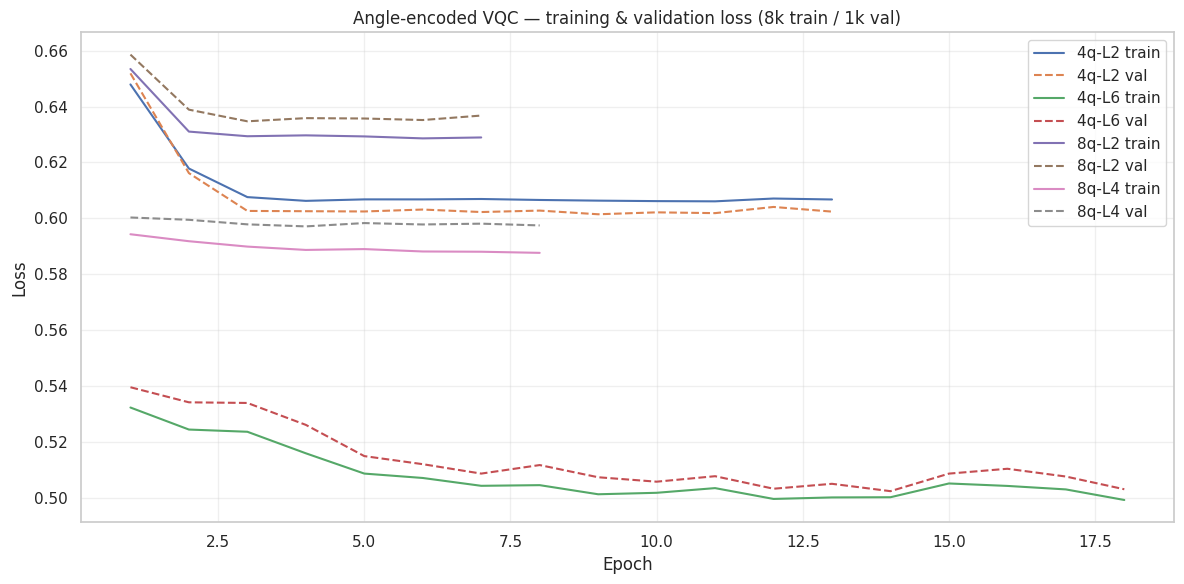

In [62]:
# Cell 22: plot train/val loss curves for all angle-encoded configs
plt.figure(figsize=(12, 6))
for (nq, nl), hist in histories_angle.items():
    epochs = np.arange(1, len(hist["train_loss"]) + 1)
    plt.plot(epochs, hist["train_loss"], label=f"{nq}q-L{nl} train")
    plt.plot(epochs, hist["val_loss"], linestyle="--", label=f"{nq}q-L{nl} val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Angle-encoded VQC — training & validation loss (8k train / 1k val)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [63]:
# Cell 23: Combine amplitude and angle benchmarks into a unified dataframe

# add encoding type column
amp_df = results_amp_serious_df.copy()
amp_df["encoding"] = "amplitude"

ang_df = results_angle_df.copy()
ang_df["encoding"] = "angle"

# merge & sort nicely
benchmark_df = pd.concat([amp_df, ang_df], ignore_index=True)
benchmark_df = benchmark_df.sort_values(["n_qubits", "encoding", "n_layers"]).reset_index(drop=True)

display(benchmark_df)


,n_qubits,n_layers,train_size,val_size,test_size,test_loss,test_acc,best_model_path,encoding
0,4,2,8000,1000,1000,0.606660,0.670,models_amp/amp_4q_L2_best.npy,amplitude
1,4,6,8000,1000,1000,0.543373,0.723,models_amp/amp_4q_L6_best.npy,amplitude
2,4,2,8000,1000,1000,0.609688,0.695,models_angle/angle_4q_L2_best.npy,angle
3,4,6,8000,1000,1000,0.511037,0.758,models_angle/angle_4q_L6_best.npy,angle
4,8,2,8000,1000,1000,0.607746,0.638,models_amp/amp_8q_L2_best.npy,amplitude
5,8,4,8000,1000,1000,0.553860,0.712,models_amp/amp_8q_L4_best.npy,amplitude
6,8,2,8000,1000,1000,0.631082,0.636,models_angle/angle_8q_L2_best.npy,angle
7,8,4,8000,1000,1000,0.601340,0.659,models_angle/angle_8q_L4_best.npy,angle


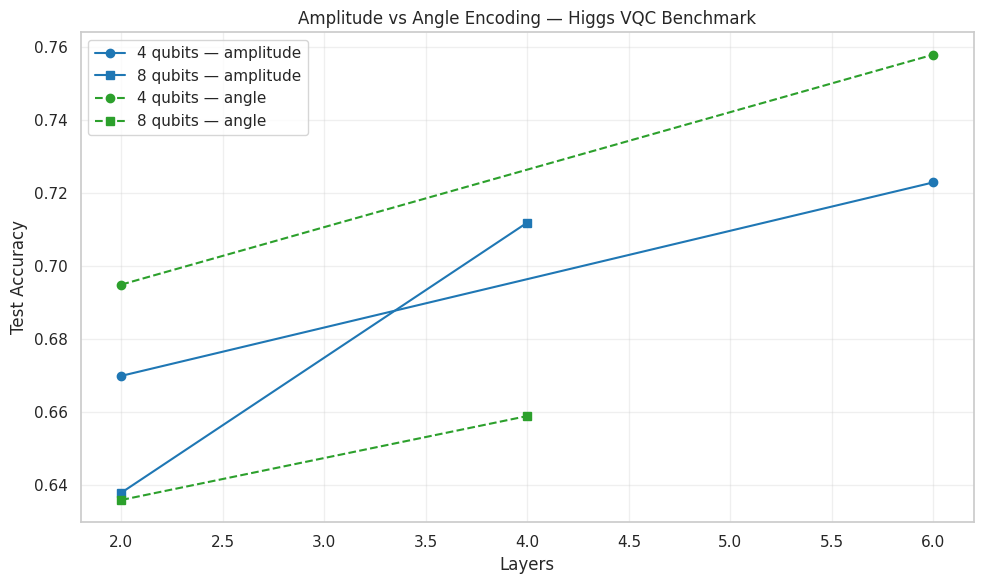

In [65]:
# Cell 24: clean benchmark comparison plot

plt.figure(figsize=(10, 6))

# Define style per encoding
amp_color = "tab:blue"
ang_color = "tab:green"

markers = {4: "o", 8: "s"}

# --- Plot amplitude encoding ---
for nq in [4, 8]:
    sub = benchmark_df[(benchmark_df["encoding"] == "amplitude") &
                       (benchmark_df["n_qubits"] == nq)]
    sub = sub.sort_values("n_layers")

    plt.plot(
        sub["n_layers"],
        sub["test_acc"],
        marker=markers[nq],
        linestyle="-",
        color=amp_color,
        label=f"{nq} qubits — amplitude",
    )

# --- Plot angle encoding ---
for nq in [4, 8]:
    sub = benchmark_df[(benchmark_df["encoding"] == "angle") &
                       (benchmark_df["n_qubits"] == nq)]
    sub = sub.sort_values("n_layers")

    plt.plot(
        sub["n_layers"],
        sub["test_acc"],
        marker=markers[nq],
        linestyle="--",
        color=ang_color,
        label=f"{nq} qubits — angle",
    )

plt.xlabel("Layers")
plt.ylabel("Test Accuracy")
plt.title("Amplitude vs Angle Encoding — Higgs VQC Benchmark")

plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [66]:
# Cell 26: helpers for confusion matrices

from sklearn.metrics import confusion_matrix

def predict_probs_angle(X, params, n_qubits, n_layers):
    exp = batch_expectations_angle(X, params, n_qubits, n_layers)
    return logit_from_expectation(exp)

def predict_probs_amp(X, params, n_qubits, n_layers):
    exp = batch_expectations_n(X, params, n_qubits, n_layers)
    return logit_from_expectation(exp)

def confusion_matrix_plot(cm, title="Confusion Matrix"):
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["background (0)", "signal (1)"],
                yticklabels=["background (0)", "signal (1)"])
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


In [67]:
# Cell 27: generate confusion matrix for selected model

def show_confusion(encoding="angle", n_qubits=4, n_layers=6):
    df = benchmark_df[
        (benchmark_df.encoding == encoding) &
        (benchmark_df.n_qubits == n_qubits) &
        (benchmark_df.n_layers == n_layers)
    ]
    if len(df) == 0:
        print("Model not found.")
        return
    
    row = df.iloc[0]
    model_path = row.best_model_path
    
    params = np.load(model_path)

    # compute predictions
    if encoding == "angle":
        probs = predict_probs_angle(X_test_sub, params, n_qubits, n_layers)
    else:
        probs = predict_probs_amp(X_test_sub, params, n_qubits, n_layers)

    preds = (probs >= 0.5).astype(int)

    # build CM
    cm = confusion_matrix(y_test_sub, preds)

    title = f"Confusion Matrix — {encoding} | {n_qubits}q-L{n_layers}"
    confusion_matrix_plot(cm, title)

    print("Accuracy:", (preds == y_test_sub).mean())
    print("Model path:", model_path)


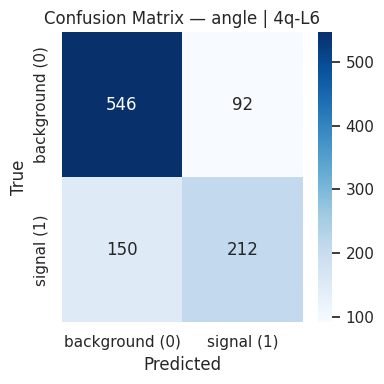

Accuracy: 0.758
Model path: models_angle/angle_4q_L6_best.npy


In [68]:
show_confusion("angle", 4, 6)


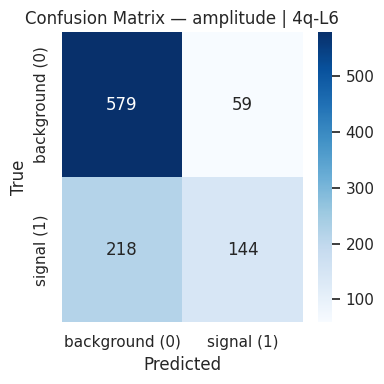

Accuracy: 0.723
Model path: models_amp/amp_4q_L6_best.npy


In [69]:
show_confusion("amplitude", 4, 6)


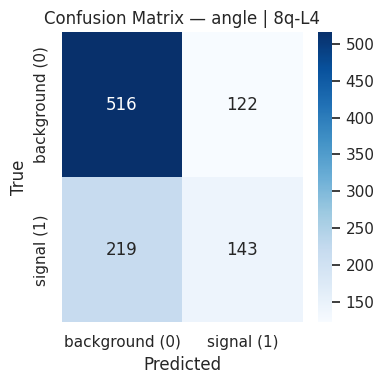

Accuracy: 0.659
Model path: models_angle/angle_8q_L4_best.npy


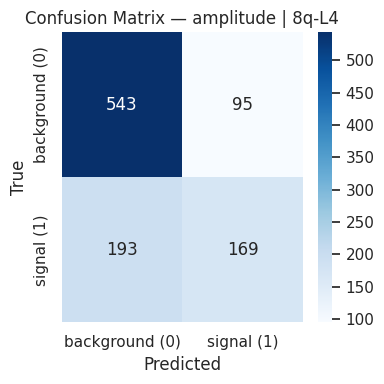

Accuracy: 0.712
Model path: models_amp/amp_8q_L4_best.npy


In [70]:
show_confusion("angle", 8, 4)
show_confusion("amplitude", 8, 4)
